# 解答例：Week4授業前課題1 アヤメの分類

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris

## アヤメの分類

Week3で使用したirisデータセットを使い、分類問題を解く練習をします。

irisデータセットはカナダのガスペ半島のある牧草地で同じ日に採取された以下の3種類のアヤメ、合計150本のデータでした。

- [Iris setosa - Wikipedia](https://en.wikipedia.org/wiki/Iris_setosa)
- [Iris virgicolor - Wikipedia](https://en.wikipedia.org/wiki/Iris_versicolor)
- [Iris virginica - Wikipedia](https://en.wikipedia.org/wiki/Iris_virginica)

4種類の特徴量（説明変数）からアヤメの種類を推測する問題が設定できます。アヤメの種類を **分類** するので、こういったものを分類問題と呼びます。

### 今回使う手法の一覧

scikit-laernを使い以下の手法で学習と推定を行っていきます。それぞれの手法についての詳細は今の段階では扱いません。ライブラリを使えばどれも気軽に利用できることや、手法毎の結果に違いがあることを簡単に見ていきます。

- 最近傍法
- ロジスティック回帰
- SVM
- 決定木
- ランダムフォレスト

## 分類問題の流れ

まず、最近傍法を例に分類問題を解く基本的な流れを紹介します。課題の後半ではこれを参考に他の手法にも適用してもらいます。

この流れについては後々より深く学び、実践していきます。今回の課題では大まかな流れの把握を行ってください。

### 練習のための準備

練習する上で結果の可視化を行いたいため、特徴量は4つの中で2つだけを使うことにします。こうすることで2次元の散布図を描き確認することができます。また、問題を単純化するためアヤメの種類を2つだけ使うことにします。分類対象が2種類の場合を **2値分類** と呼び、それ以上の **多値分類** とは区別をします。それぞれで手法や評価方法が変わります。今回はまずより基本的な2値分類を行います。

### 【課題1】練習のために特徴量とカテゴリを選択

選び方は合計18通りありますが、以下の組み合わせで練習することにします。irisデータセットをWeek3同様に取得した後、データフレームからこれらを抜き出してください。

- virgicolorとvirginica
- sepal_lengthとpetal_length

**＜実際の問題では？＞**

実際の問題を解く上でも結果の可視化は有効です。しかし、そのために学習や推定に使う特徴量を2つに絞るのは望ましくありません。そのため学習や推定は多次元で行い、可視化をする際にだけ主成分分析などの特徴抽出手法を適用するといったことが行われます。また、Week3で利用した散布図行列を使い可視化することも可能です。

（解説）

種類の抜き出しは「条件を指定して行を抽出」の操作になります。queryメソッドまたはboolean indexingを用いることになります。

queryメソッドを使う場合、`Species == [1, 2]`のように書くとラベルが1または2の行を抜き出すことができます。virgicolorとvirginicaはこのデータセットでは整数1と2で記録されています。boolean indexingについては別解とします。

特徴量の抜き出しは「列の抽出」の操作になります。これはlocなどを使うことになります。

それぞれの返り値はDataFrameなので、繋げて書くことができます。この場合はqueryとlocは順番を入れ替えても同じ結果です。

In [2]:
iris_dataset = load_iris()
X = pd.DataFrame(iris_dataset.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
y = pd.DataFrame(iris_dataset.target, columns=["Species"])
df = pd.concat([X, y], axis=1)

df_selected = df.query("Species == [1, 2]").loc[:, ["sepal_length", "petal_length", "Species"]]
df_selected.head()

,sepal_length,petal_length,Species
50,7.0,4.7,1
51,6.4,4.5,1
52,6.9,4.9,1
53,5.5,4.0,1
54,6.5,4.6,1


In [3]:
# この場合は順番は逆でも同じ結果
df_selected = df.loc[:, ["sepal_length", "petal_length", "Species"]].query("Species == [1, 2]")
df_selected.head()

,sepal_length,petal_length,Species
50,7.0,4.7,1
51,6.4,4.5,1
52,6.9,4.9,1
53,5.5,4.0,1
54,6.5,4.6,1


（別解）

queryメソッドにおいて`Species == [1, 2]`は`Species in [1, 2]`と書くこともできます。

In [4]:
df_selected = df.query("Species in [1, 2]").loc[:, ["sepal_length", "petal_length", "Species"]]
df_selected.head()

,sepal_length,petal_length,Species
50,7.0,4.7,1
51,6.4,4.5,1
52,6.9,4.9,1
53,5.5,4.0,1
54,6.5,4.6,1


（別解）

boolean indexingを行う場合は、Seriesのisinメソッドを使います。このメソッドは指定した値のどれかを含むかどうかのBool値を返します。

[pandas.Series.isin — pandas 0.25.0 documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.isin.html#pandas.Series.isin)

[Indexing and selecting data — pandas 0.25.0 documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#boolean-indexing)

In [5]:
df[df["Species"].isin([1, 2])].head()

,sepal_length,sepal_width,petal_length,petal_width,Species
50,7.0,3.2,4.7,1.4,1
51,6.4,3.2,4.5,1.5,1
52,6.9,3.1,4.9,1.5,1
53,5.5,2.3,4.0,1.3,1
54,6.5,2.8,4.6,1.5,1


### 【問題2】データの分析

まずはデータの分析を行いますが、これはWeek3の課題1で行いました。その際出力した散布図行列を見ることで、先ほどの18通りそれぞれの散布図も確認できます。sepal_lengthとpetal_lengthを使い、virgicolorとvirginicaを分類するのは少し難しそうな状況であることが分かるはずです。

ここでは復習を兼ねて、抜き出したデータの散布図と箱ひげ図（boxplot）、バイオリン図（violinplot）を表示してください。

**＜実際の問題では？＞**

このデータ分析の結果を元に前処理として特徴量エンジニアリングを行っていきます。

今回はsepal_lengthとpetal_lengthを抜き出しましたが、分析した上で、問題を少々難しくするための前処理をしたと言えます。

（解説）

Week3の授業前課題1の復習です。

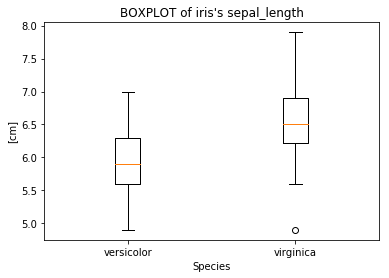

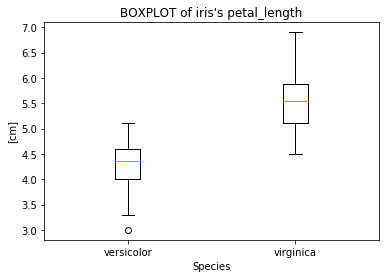

In [6]:
features = ["sepal_length", "petal_length"]

for feature in features:
    plt.boxplot([df[df["Species"]==1][feature], df[df["Species"]==2][feature]])
    plt.xticks([1, 2], iris_dataset.target_names[1:])
    plt.title("BOXPLOT of iris's {}".format(feature))
    plt.ylabel('[cm]')
    plt.xlabel('Species')
    plt.show()

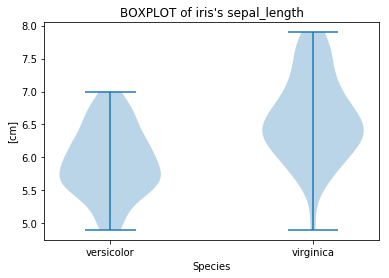

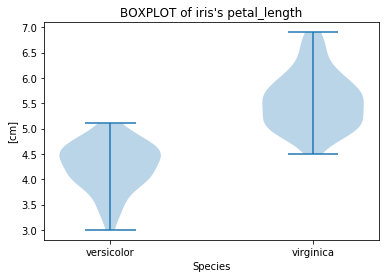

In [7]:
features = ["sepal_length", "petal_length"]

for feature in features:
    plt.violinplot([df[df["Species"]==1][feature], df[df["Species"]==2][feature]])
    plt.xticks([1, 2], iris_dataset.target_names[1:])
    plt.title("BOXPLOT of iris's {}".format(feature))
    plt.ylabel('[cm]')
    plt.xlabel('Species')
    plt.show()

どちらの特徴量においても重なり合っている部分があるため、ひとつの特徴量だけで分類することは難しそうである。

### 前処理

データに加工をしていきます。

### 【問題3】前処理・訓練用データと検証用データの分割

前処理の一貫として、訓練用（train）データと検証用（validation）データの分割を行います。今回は訓練用データ75%、検証用データ25%として分割してください。

scikit-learnの`train_test_split`が利用できます。公式ドキュメントのExamplesを参考に動かしてください。

[sklearn.model_selection.train_test_split — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

**＜注意点＞**

データの分析まではPandasのDataFrameを使用してきました。しかし、scikit-learnはNumPyのndarrayを想定して作られています。そのため、この段階でndarrayへの変換を行いましょう。特徴量（説明変数）をX、正解（目的変数）をyというndarrayに格納します。

**＜分割する理由＞**

分類問題の目的は未知のデータを正しく分類することです。その目的が達成できているかを確認するため、実際には答えの分かっているデータの一部を学習には使わず残しておきます。この学習に使用していないデータで推定を行い、そこから求めた指標値によって検証します。学習に使うデータを訓練用データ、検証に使うデータが検証用データで、一般的に7対3から8対2程度の割合にします。

（解説）

特徴量Xとラベルy、検証データの割合を引数として渡します。

シャッフルされランダムに分割されますが、シード値も与えていれば繰り返し実行しても同じ分割になります。

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_selected.iloc[:, :-1], df_selected.loc[:, "Species"], test_size=0.25, random_state=42)

print("X_train.shape : {}, X_test.shape : {}".format(X_train.shape, X_test.shape))

X_train.shape : (75, 2), X_test.shape : (25, 2)


### 【問題4】前処理・標準化

分類精度をあげるための加工を行います。手法ごとに適切な方法は異なりますが、ここでは一例として **標準化** を行うことにします。

標準化を行うライブラリもscikit-learnに用意されています。これを使って標準化してください。

[sklearn.preprocessing.StandardScaler — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

**＜注意点＞**

標準化は訓練用のデータで`fit`を行い、訓練用、検証用双方のデータに`transform`を行います。検証用データは学習の段階には存在しない未知のデータの代わりなので、標準化のための平均や標準偏差の計算に使ってはいけません。

**＜実際の問題での前処理は？＞**

アヤメのデータセットのように綺麗で扱いやすい状況で提供されることはまずありません。分析を行いながら、様々な加工が必要になってきます。例えばWeek3の課題2で行った欠損値の確認の後、場合により欠損値の補間も行います。外れ値の確認や、複数のデータセットの整理などもあります。

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)

X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

### 【問題5】学習と推定

最近傍法（k-nearest neighbors, k-nn）で学習を行います。scikit-learnの公式ドキュメントのExamplesを参考に、k-nnの学習を行ってください。ここで入力するのは訓練用データです。

[sklearn.neighbors.KNeighborsClassifier — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

学習が終わった後、検証用データを`predict`メソッドに入力し、推定を行ってください。

パラメータが複数ありますが、今はそれらの理解を重視しません。最も基本的な要素として、`n_neighbors`の数があるため、これは複数試してみましょう。デフォルトの5、および1と3を最低限行ってください。5の場合を`5-nn`、3の場合を`3-nn`のように呼びます。

In [10]:
from sklearn.neighbors import KNeighborsClassifier
neigh_1 = KNeighborsClassifier(n_neighbors=1)
neigh_3 = KNeighborsClassifier(n_neighbors=3)
neigh_5 = KNeighborsClassifier(n_neighbors=5)
neigh_1.fit(X_train_transformed, y_train)
neigh_3.fit(X_train_transformed, y_train)
neigh_5.fit(X_train_transformed, y_train)
y_pred_neigh_1 = neigh_1.predict(X_test_transformed)
y_pred_neigh_3 = neigh_1.predict(X_test_transformed)
y_pred_neigh_5 = neigh_1.predict(X_test_transformed)

In [11]:
print("1-nnの推定結果：{}".format(y_pred_neigh_1))
print("3-nnの推定結果：{}".format(y_pred_neigh_3))
print("5-nnの推定結果：{}".format(y_pred_neigh_5))

1-nnの推定結果：[2 2 2 1 1 1 2 2 1 1 1 1 2 2 2 1 1 1 1 1 2 1 1 1 2]
3-nnの推定結果：[2 2 2 1 1 1 2 2 1 1 1 1 2 2 2 1 1 1 1 1 2 1 1 1 2]
5-nnの推定結果：[2 2 2 1 1 1 2 2 1 1 1 1 2 2 2 1 1 1 1 1 2 1 1 1 2]


### 【問題6】評価

検証用データの特徴量を入力して得られた推定値と、検証用データの正解値の近さを計算し、学習したモデルを評価します。

2値分類を評価するための指標値には **accuracy**、**precision**、**recall**、**f値** があります。それぞれの意味を理解するには、 **混同行列（confusion matrix）** を見ることになります。

- scikit-learnを使い4種類の指標を計算する
- 混同行列をscikit-learnを使い表示する
- 4種類の指標値の意味について簡単に調査して文章でまとめる

[sklearn.metrics.accuracy_score — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

[sklearn.metrics.precision_score — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)

[sklearn.metrics.recall_score — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)

[sklearn.metrics.f1_score — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)

[sklearn.metrics.confusion_matrix — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

（解説）

まず「scikit-learnを使い4種類の指標を計算する」と「混同行列をscikit-learnを使い表示する」についてです。

それぞれの関数に正解値と推定値を引数として渡します。

以下の解答例では5つをまとめて計算する関数を作っています。

ライブラリのimportは

`from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix`

のようにもできますが、ここでは`from sklearn import metrics`とすることで複数の関数を並べずに書いています。

In [12]:
from sklearn import metrics

def evaluate(y_true, y_pred):
    """
    2値分類の評価指標を計算する
    """
    acc = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    confusion = metrics.confusion_matrix(y_test, y_pred)
    return acc, precision, recall, f1, confusion

print("1-nn")
print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(*evaluate(y_test, y_pred_neigh_1)))
print("------")

print("3-nn")
print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(*evaluate(y_test, y_pred_neigh_3)))
print("------")

print("5-nn")
print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(*evaluate(y_test, y_pred_neigh_5)))

1-nn
acc : 0.8
precision : 0.8
recall : 0.8571428571428571
f1 : 0.8275862068965518
confusion matrix 
 [[12  2]
 [ 3  8]]
------
3-nn
acc : 0.8
precision : 0.8
recall : 0.8571428571428571
f1 : 0.8275862068965518
confusion matrix 
 [[12  2]
 [ 3  8]]
------
5-nn
acc : 0.8
precision : 0.8
recall : 0.8571428571428571
f1 : 0.8275862068965518
confusion matrix 
 [[12  2]
 [ 3  8]]


（補足）

`format(*evaluate(y_train, y_pred_neigh_3)`とアスタリスクを付けていますが、これはtupleで返ってきた値を **アンパック** してformatメソッドに渡しています。

formatメソッドは **可変長引数** として表示したい値を受け取るので、これに適した形にするためです。

もしもアスタリスクを付けないと以下のようなエラーとなります。これは5種類の値をまとめて1つのtupleとしてformatメソッドに渡しているため、値の数が足りないというエラーになっています。

In [13]:
print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(evaluate(y_train, y_pred_neigh_1)))

IndexError: tuple index out of range

この違いを比較するための関数を用意しました。

可変長引数は`*args`のようにアスタリスクを1つ付けて書きます。

例1のように`1, ,2 ,3`と渡すと、argsにはtupleで`(1, 2, 3)`と入ります。

一方、例2のように`(1, 2, 3)`と渡すと、argsにはtupleで`((1, 2, 3),)`とtupleの中にtupleが入ります。これが上のエラーの状態です。

このエラーを解決するために例3のように`*(1, 2, 3)`とアンパックを行うと、例1と同様にtupleで`(1, 2, 3)`と入ります。

In [14]:
def sample_function(*args):
    print("type : {}".format(type(args)))
    print(args)
    
# 例1
sample_function(1, 2, 3)
# 例2
sample_function((1, 2, 3))
# 例3
sample_function(*(1, 2, 3))

type : <class 'tuple'>
(1, 2, 3)
type : <class 'tuple'>
((1, 2, 3),)
type : <class 'tuple'>
(1, 2, 3)


（解説）

「4種類の指標値の意味について簡単に調査して文章でまとめる」についてです。

4種類の指標値は混同行列を見ながら考えると分かりやすいです。

まずはscikit-learnの公式ドキュメントにある、混同行列をヒートマップとして可視化する関数を使ってみます。

[Confusion matrix — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

Confusion matrix, without normalization
[[12  2]
 [ 3  8]]


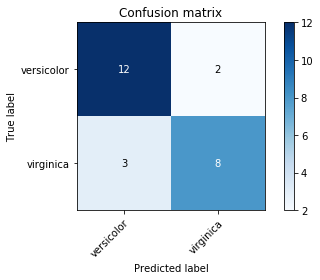

In [15]:
# 公式ドキュメントの関数を若干修正して使用

from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_neigh_1, classes=iris_dataset.target_names,
                      title='Confusion matrix')
plt.show()

混同行列はある実際の値に対して、推定された値ごとの個数をまとめたものです。

上の例だと次のように読み解きます。

- 左上が正解がversicolorの中でversicolorと正しく推定されたものが12個。
- 右上が正解がversicolorの中でvirginicaと間違って推定されたものが2個。
- 左下が正解がvirginicaの中でversicolorと間違って推定されたものが3個。
- 右下が正解がvirginicaの中でvirginicaと正しく推定されたものが8個。

ここでは2値分類であるため、「virginicaであるかどうかを判定する問題」と捉えると、virginicaを **Positive（陽性）** 、versicolorを **Negative（陰性）** と呼ぶことになります。scikit-learnで出力した混同行列では、左上がTrue Negative(TN)、右上がFalse Positive(FP)、左下がFalse Negative(FN)、右下がTrue Positive(TP)と呼ぶことになります。

そのように定義した場合、各指標値は以下の計算式で求まります。



Accuracy（成果率）は「全ての中で正解した割合」　$\frac{TP+TN}{TP+TN+FP+FN}$

Precision（適合率）は「Positiveだと判定された中で実際にPositiveな割合」　$\frac{TP}{TP+FP}$

Recall（再現率）は「実際にはPositiveなものの中でPositiveだと判定された割合」　$\frac{TP}{TP+FN}$

F1は「PrecisionとRecallの調和平均」　 $2\times\frac{Precision*Recall}{Precision+Recall}$

どの値も大きい方が精度が良いと言えます。

Accuracyは最も単純な指標値ですが、例えばNegativeが99個、Positiveが1個の場合、100個全てNegativeと判定すると、**(0+99)/(0+99+0+1)=0.99** となります。これは一見高い値ですが、重大な病気を持つ患者1人を見つけたい場合には不適切です。

この時Recallを見ると、**0/(0+1)=0**となります。重大な病気を持つ患者が見つけられていないことがはっきりと分かります。

100個全てPositiveと判定すればRecallを大きくすることはできます。**1/(1+0)=1** となります。しかし、全員が病気を持つと判定するのであればその予測には意味がありません。健康（Negative）なのに、病気を持っている（Positive）と間違って判定されたFalse Netativeが99人もいます。

Precisionを見ると**1/(1+99)=0.01**となります。Positiveだと選ばれた中に間違いが多いことがはっきりと分かります。

全て網羅していなくとも、選ばれた中に間違いが少ない状態を目指したい場合はPrecisionを上げるようにします。例えばスパムメールの判定タスクです。疑わしきは罰せずということになります。

見逃すことがまずい不正アクセス検知のタスクでは、Precisionがある程度下がってもRecallを上げたいとなるでしょう。疑わしきは罰するということになります。

他の例では、採用活動で良い人材を漏れなく合格にするか、会社に合わない人材を合格させないようにするかといったことが考えられます。

このように、状況に応じてRecallとPrecisionをどの程度優先したいかということは変わってきます。判定のしきい値をどうするかという違いになってきます。

＊機械学習の手法によってはPositiveである確率で予測するものも多いです。この時判定のしきい値を0.5から上下させることで、RecallとPrecisionの値は変化していきます。

RecallとPrecisionのバランスをとったものとしてF1があり、ひとまずこれを見てみるということは多いです。また、AUCという指標値もよく使われます。


（補足）

使う頻度は下がりますが、混同行列からは他の計算も可能です。Wikipediaの以下の記事が参考になります。

[Evaluation of binary classifiers - Wikipedia](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers)

### 【問題7】可視化

評価の一貫として可視化を行います。今回の場合2次元の特徴量で分類を行いましたから、散布図で可視化が可能です。以下にどう分割するかという **決定領域** を描く関数を用意しました。これを利用して可視化を行ってください。Xとyには訓練用データまたは検証用データを与えます。

3-nnの決定領域を表示した例が以下です。

[![Image from Gyazo](https://t.gyazo.com/teams/diveintocode/a40d4c5f7ec594f5c7ee9e1b58fab96b.png)](https://diveintocode.gyazo.com/a40d4c5f7ec594f5c7ee9e1b58fab96b)

この例では訓練用データをプロットし、どのように学習したかを見ています。一方で、検証用データをプロットすればどういった特徴量のものが間違って分類されたかを見ることができます。


In [16]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

（解説）

関数に適切な形で引数を渡してください。以下の例ではfor文でまとめて表示できるようにしています。

この決定領域によってこの手法がどのように分類を行なっているかの確認が行えます。

1-nnではその地点から最も近い1つの訓練データのラベルを推定結果とするため、領域は訓練データへの距離によって描かれています。訓練データは完全に分類されることになります。

3-nnでは3つの訓練データのラベルから多数決によって推定結果とするため、訓練データに対しても間違って推定されている点があります。

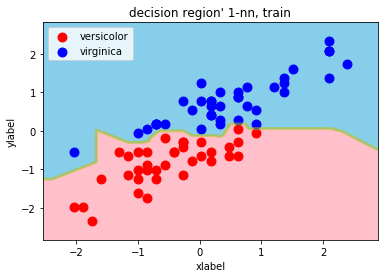

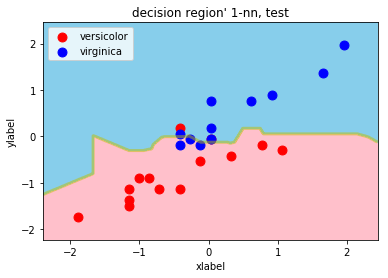

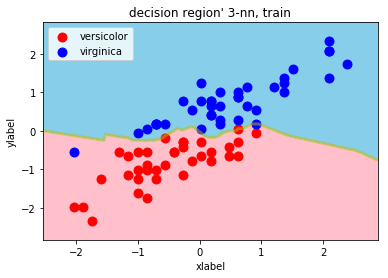

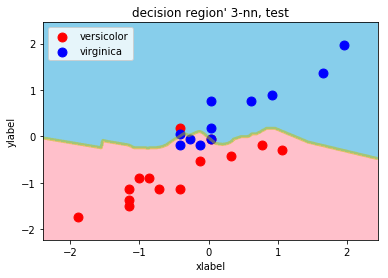

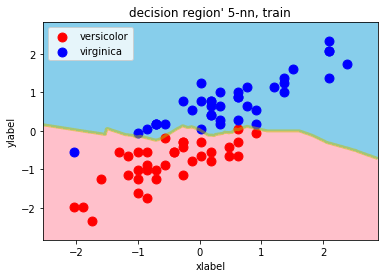

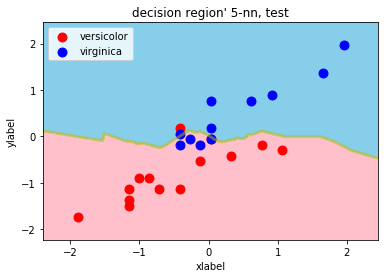

In [17]:
models = [neigh_1, neigh_3, neigh_5]
model_names = ["1-nn", "3-nn", "5-nn"]
for model, model_name in zip(models, model_names):
    decision_region(X_train_transformed, y_train, model, title="decision region' {}, {}".format(model_name, "train"))
    decision_region(X_test_transformed, y_test, model, title="decision region' {}, {}".format(model_name, "test"))

### 手法の改善

実際の問題では指標値や可視化を元に手法を改善していきますが、この課題では扱いません。

## 各手法の比較

他の手法も基本的な流れは同様です。他の手法でも学習から可視化までを行っていきます。

### 【問題8】他の手法の学習

以下の全ての手法について学習・推定・評価・可視化を行ってください。そして、指標値を１つの表にまとめてください。その表と決定領域を利用して結果を簡単に考察してください。どの手法がどの指標値で良かったかや、どういった決定領域になっていたかを述べてください。

- 最近傍法
- ロジスティック回帰
- SVM
- 決定木
- ランダムフォレスト

公式ドキュメントへのリンクは以下です。それぞれ調整すべき引数（ハイパーパラメータ）がありますが、この課題では扱いません。まずはデフォルトの値で実行してください。

- [sklearn.neighbors.KNeighborsClassifier — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
- [sklearn.linear_model.LogisticRegression — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [sklearn.svm.SVC — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
- [sklearn.tree.DecisionTreeClassifier — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
- [sklearn.ensemble.RandomForestClassifier — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

**＜実際の問題では？＞**

ハイパーパラメータの調整は **パラメータチューニング** と呼ばれる工程で、その手法としてグリッドサーチなどが存在します。

（解説）

for文でまとめて計算するコードにしています。

1-nn
acc : 0.8
precision : 0.8
recall : 0.8571428571428571
f1 : 0.8275862068965518
confusion matrix 
 [[12  2]
 [ 3  8]]


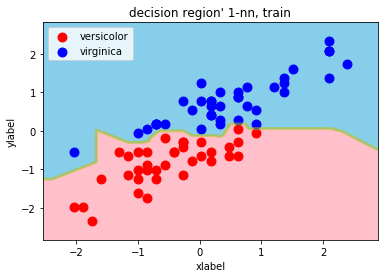

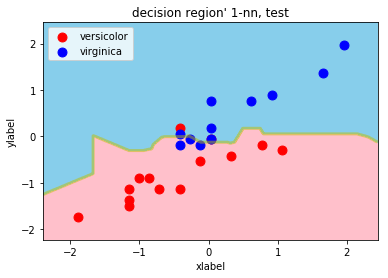

3-nn
acc : 0.8
precision : 0.8
recall : 0.8571428571428571
f1 : 0.8275862068965518
confusion matrix 
 [[12  2]
 [ 3  8]]


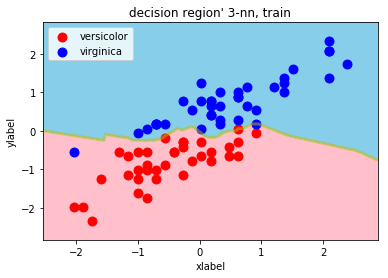

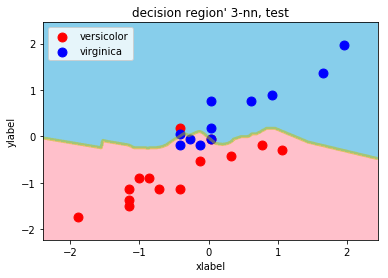

5-nn
acc : 0.8
precision : 0.7647058823529411
recall : 0.9285714285714286
f1 : 0.8387096774193549
confusion matrix 
 [[13  1]
 [ 4  7]]


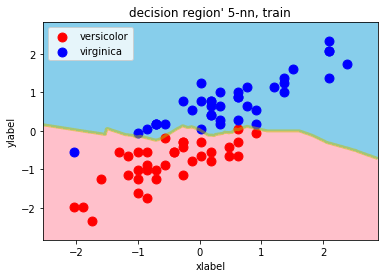

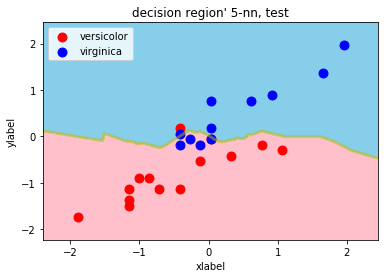

Logistic Regression
acc : 0.84
precision : 0.8125
recall : 0.9285714285714286
f1 : 0.8666666666666666
confusion matrix 
 [[13  1]
 [ 3  8]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


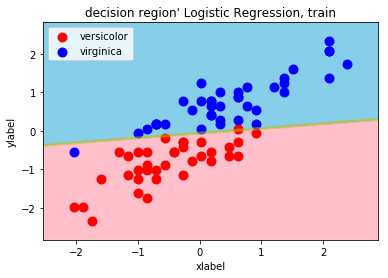

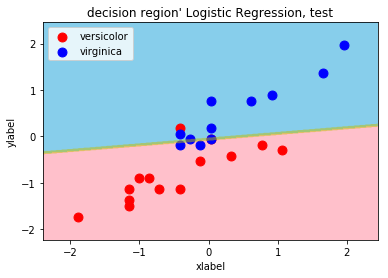

SVM
acc : 0.84
precision : 0.8571428571428571
recall : 0.8571428571428571
f1 : 0.8571428571428571
confusion matrix 
 [[12  2]
 [ 2  9]]


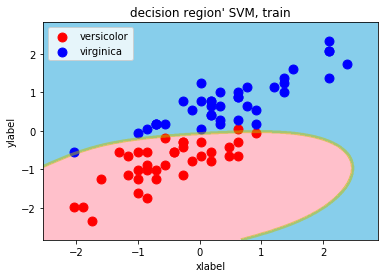

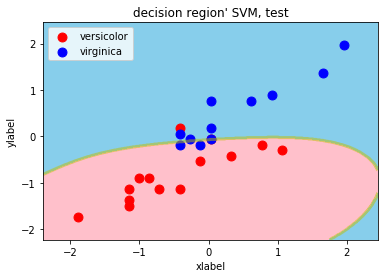

Decision Tree
acc : 0.84
precision : 0.8125
recall : 0.9285714285714286
f1 : 0.8666666666666666
confusion matrix 
 [[13  1]
 [ 3  8]]


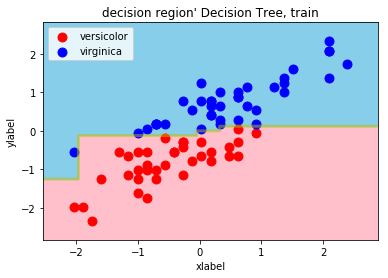

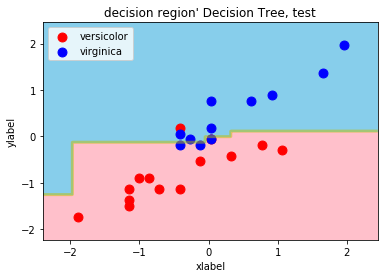

Random Forest
acc : 0.84
precision : 0.8571428571428571
recall : 0.8571428571428571
f1 : 0.8571428571428571
confusion matrix 
 [[12  2]
 [ 2  9]]


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


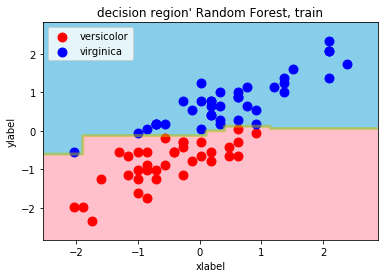

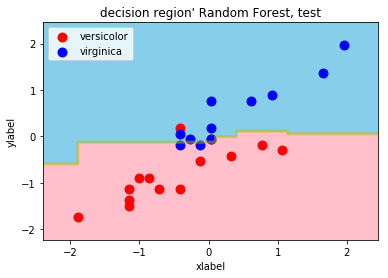

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

neigh_1 = KNeighborsClassifier(n_neighbors=1)
neigh_3 = KNeighborsClassifier(n_neighbors=3)
neigh_5 = KNeighborsClassifier(n_neighbors=5)
logistic_reg = LogisticRegression()
svc = SVC()
tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()


models = [neigh_1, neigh_3, neigh_5, logistic_reg, svc, tree, random_forest]
model_names = ["1-nn", "3-nn", "5-nn", "Logistic Regression", "SVM", "Decision Tree", "Random Forest"]
for model, model_name in zip(models, model_names):
    print(model_name)
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)
    
    print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(*evaluate(y_test, y_pred)))
    decision_region(X_train_transformed, y_train, model, title="decision region' {}, {}".format(model_name, "train"))
    decision_region(X_test_transformed, y_test, model, title="decision region' {}, {}".format(model_name, "test"))

### 【問題9】（アドバンス課題）標準化の有無の比較

前処理として標準化を行いましたが、これを行わなかった場合どのような結果が得られるでしょうか。各手法に対しての指標値の表と決定領域の図を作成し比較および考察を行ってください。考察には標準化が機械学習の前処理としてどのような意味があるかを絡めてください。

（解説）

標準化していないものも含めて問題8同様のことを行なってみます。X_trainやX_testがDataFrameになっている場合、決定領域可視化のコードでは入力にndarrayを想定しているため変換が必要な点に注意です。

例えば標準化を行なっても距離関係は変わらないため、最近傍法ではそれぞれ同じ結果となっています。

この例ではロジスティック回帰のみ結果が変わっています。

1-nn
<with standard scaling>
acc : 0.8
precision : 0.8
recall : 0.8571428571428571
f1 : 0.8275862068965518
confusion matrix 
 [[12  2]
 [ 3  8]]


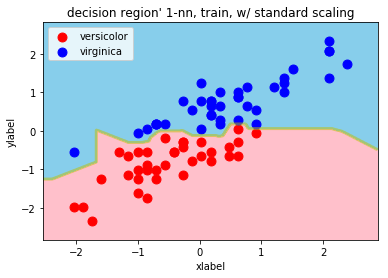

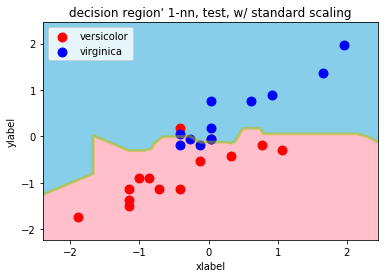

<without standard scaling>
acc : 0.8
precision : 0.8
recall : 0.8571428571428571
f1 : 0.8275862068965518
confusion matrix 
 [[12  2]
 [ 3  8]]


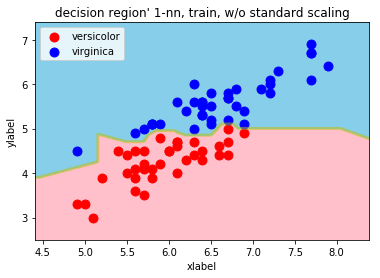

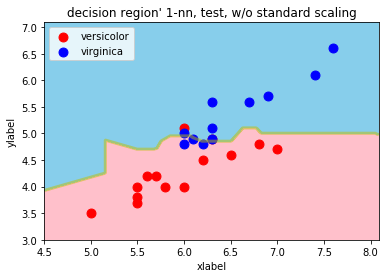

3-nn
<with standard scaling>
acc : 0.8
precision : 0.8
recall : 0.8571428571428571
f1 : 0.8275862068965518
confusion matrix 
 [[12  2]
 [ 3  8]]


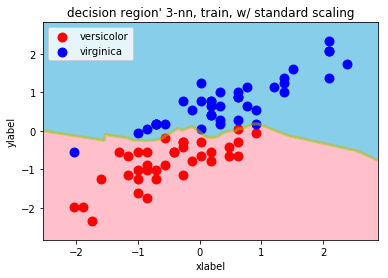

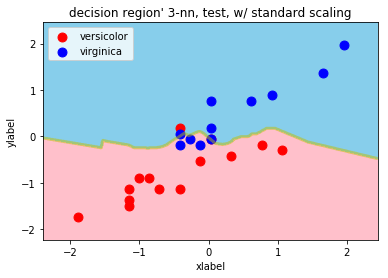

<without standard scaling>
acc : 0.8
precision : 0.8
recall : 0.8571428571428571
f1 : 0.8275862068965518
confusion matrix 
 [[12  2]
 [ 3  8]]


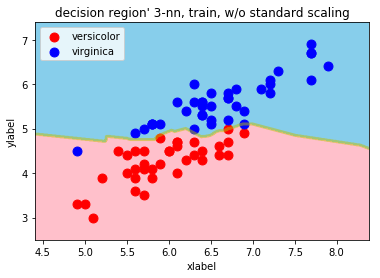

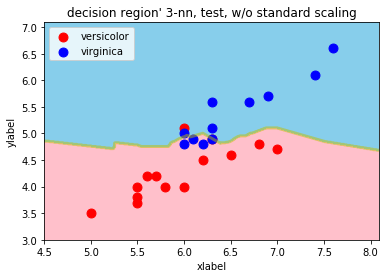

5-nn
<with standard scaling>
acc : 0.8
precision : 0.7647058823529411
recall : 0.9285714285714286
f1 : 0.8387096774193549
confusion matrix 
 [[13  1]
 [ 4  7]]


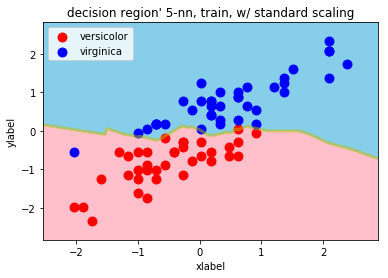

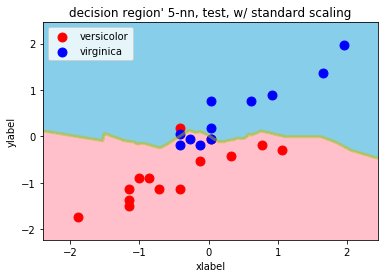

<without standard scaling>
acc : 0.8
precision : 0.7647058823529411
recall : 0.9285714285714286
f1 : 0.8387096774193549
confusion matrix 
 [[13  1]
 [ 4  7]]


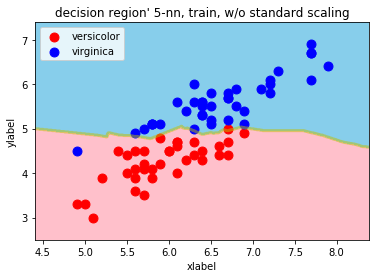

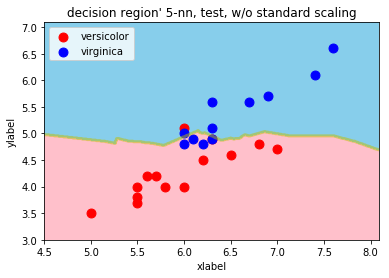

Logistic Regression
<with standard scaling>
acc : 0.84
precision : 0.8125
recall : 0.9285714285714286
f1 : 0.8666666666666666
confusion matrix 
 [[13  1]
 [ 3  8]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


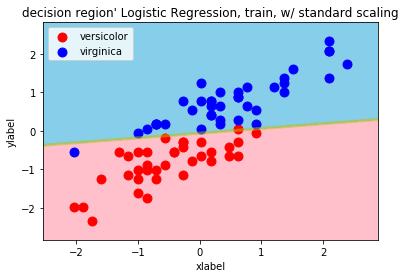

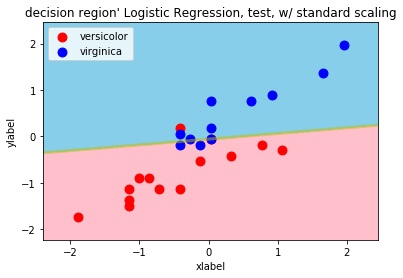

<without standard scaling>
acc : 0.88
precision : 0.9230769230769231
recall : 0.8571428571428571
f1 : 0.888888888888889
confusion matrix 
 [[12  2]
 [ 1 10]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


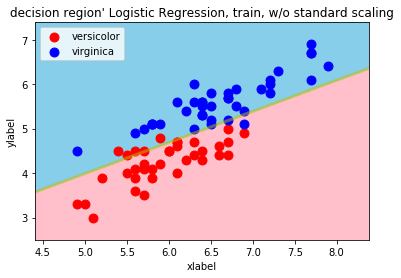

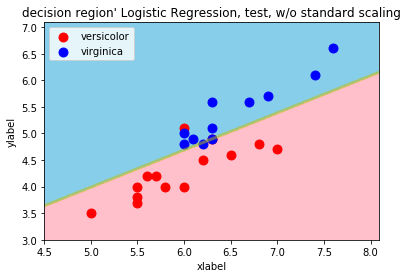

SVM
<with standard scaling>
acc : 0.84
precision : 0.8571428571428571
recall : 0.8571428571428571
f1 : 0.8571428571428571
confusion matrix 
 [[12  2]
 [ 2  9]]


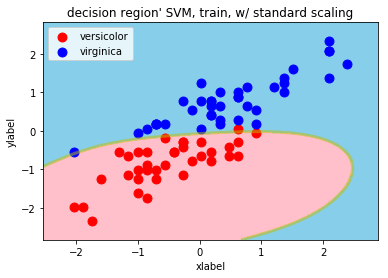

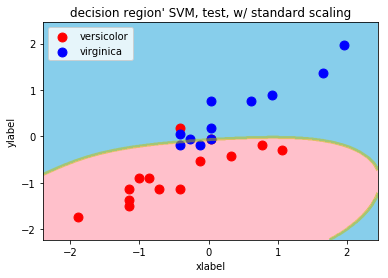

<without standard scaling>
acc : 0.84
precision : 0.8571428571428571
recall : 0.8571428571428571
f1 : 0.8571428571428571
confusion matrix 
 [[12  2]
 [ 2  9]]


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


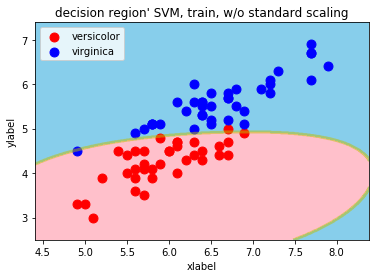

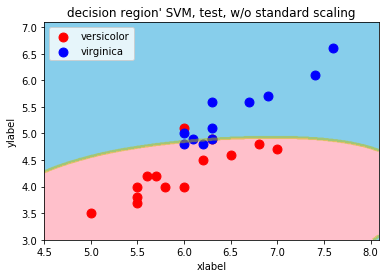

Decision Tree
<with standard scaling>
acc : 0.84
precision : 0.8125
recall : 0.9285714285714286
f1 : 0.8666666666666666
confusion matrix 
 [[13  1]
 [ 3  8]]


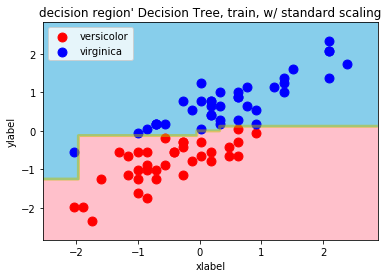

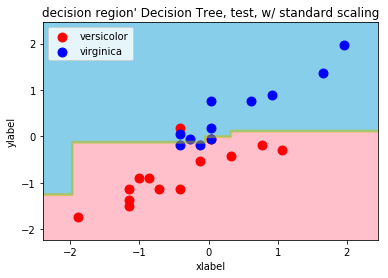

<without standard scaling>
acc : 0.84
precision : 0.8125
recall : 0.9285714285714286
f1 : 0.8666666666666666
confusion matrix 
 [[13  1]
 [ 3  8]]


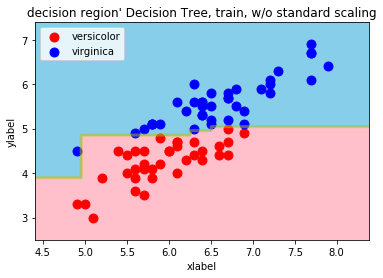

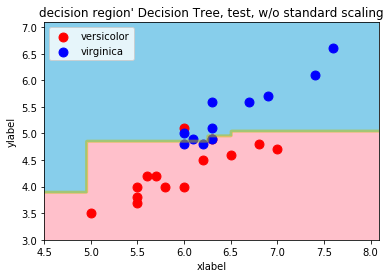

Random Forest
<with standard scaling>
acc : 0.84
precision : 0.8125
recall : 0.9285714285714286
f1 : 0.8666666666666666
confusion matrix 
 [[13  1]
 [ 3  8]]


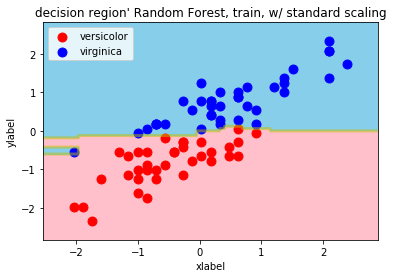

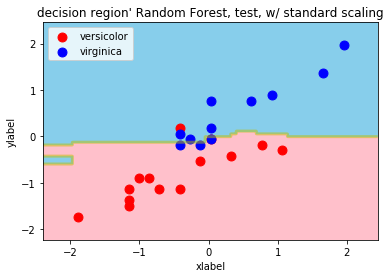

<without standard scaling>
acc : 0.8
precision : 0.7647058823529411
recall : 0.9285714285714286
f1 : 0.8387096774193549
confusion matrix 
 [[13  1]
 [ 4  7]]


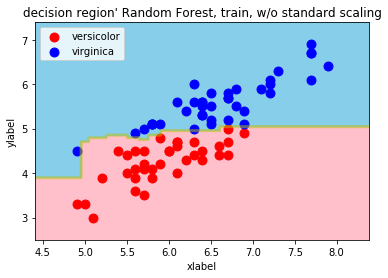

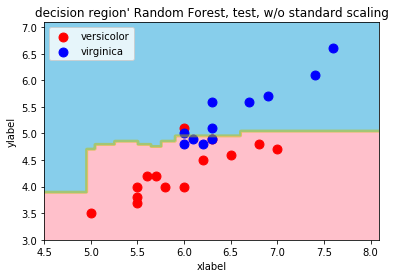

In [19]:
X_train_ndarray = np.array(X_train)
X_test_ndarray = np.array(X_test)

models = [neigh_1, neigh_3, neigh_5, logistic_reg, svc, tree, random_forest]
model_names = ["1-nn", "3-nn", "5-nn", "Logistic Regression", "SVM", "Decision Tree", "Random Forest"]
for model, model_name in zip(models, model_names):
    print(model_name)
    
    print("<with standard scaling>")
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)
    print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(*evaluate(y_test, y_pred)))
    decision_region(X_train_transformed, y_train, model, title="decision region' {}, {}, w/ standard scaling".format(model_name, "train"))
    decision_region(X_test_transformed, y_test, model, title="decision region' {}, {}, w/ standard scaling".format(model_name, "test"))
    
    print("<without standard scaling>")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(*evaluate(y_test, y_pred)))
    decision_region(X_train_ndarray, y_train, model, title="decision region' {}, {}, w/o standard scaling".format(model_name, "train"))
    decision_region(X_test_ndarray, y_test, model, title="decision region' {}, {}, w/o standard scaling".format(model_name, "test"))

### 【問題10】（アドバンス課題）全ての目的変数を使用して精度が高い手法

ここまではアヤメの種類を減らし2値分類を行ってきましたが、3種類全てを使った多値分類を行います。学習と推定、評価を行って、最も精度の高い手法を探してください。

**＜多値になることでの変更点＞**

指標値precision、recall、f値はライブラリのパラメータをデフォルトから変更する必要があります。マイクロ平均やマクロ平均という考え方を使います。

決定領域を可視化する前述の関数は適切に書き換える必要があります。以下が出力例です。

[![Image from Gyazo](https://t.gyazo.com/teams/diveintocode/6ef74d6498e42db50c8aed515a305bcb.png)](https://diveintocode.gyazo.com/6ef74d6498e42db50c8aed515a305bcb)

ロジスティック回帰やSVMは2値分類を基本とした手法で、多値分類には工夫が必要ですが、scikit-learnでは自動的に判断して処理が行われるため変更は必要ありません。

（解説）

変更箇所はそれほど多くありません。

- 抽出を列のみにする
- 決定領域の可視化関数でtarget_names、n_class、scatter_color、contourf_colorを3値に対応させる
- 指標値計算の関数の`average`引数を与える

以下の例ではSVMとランダムフォレストは完全に正解することができました。シード値次第ではそのようにならない場合もあります。

（補足）

PrecisionやRecallの計算のマイクロ平均やマクロ平均というのは、計算順序の違いになります。

マクロ平均はそれぞれの種類をPositiveだと考えた2値分類のPrecisionやRecallを求めた後に、平均をとります。

一方、マイクロ平均は混同行列から直接計算することを考えます。この時、それぞれの種類に対して合っていればTP、間違って入ればFPまたはFNとします。この場合はAccuracyもPrecisionもRecallもF1も同じ値になります。

マクロ平均かマイクロ平均かで、ある種類のラベルが少ないような不均衡なデータの場合に、その影響の仕方が変わります。

以下ではまずマクロ平均を求めています。

In [20]:
iris_dataset = load_iris()
X = pd.DataFrame(iris_dataset.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
y = pd.DataFrame(iris_dataset.target, columns=["Species"])
df = pd.concat([X, y], axis=1)

df_selected = df.loc[:, ["sepal_length", "petal_length", "Species"]]

X_train, X_test, y_train, y_test = train_test_split(df_selected.iloc[:, :-1], df_selected.loc[:, "Species"], test_size=0.25, random_state=42)

print("X_train.shape : {}, X_test.shape : {}".format(X_train.shape, X_test.shape))

scaler = StandardScaler()

scaler.fit(X_train)

X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

X_train.shape : (112, 2), X_test.shape : (38, 2)


In [21]:
def decision_region_3dim(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['setosa', 'versicolor', 'virginica']):
    """
    3値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 3)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['green', 'red', 'blue']
    contourf_color = ['lightgreen', 'pink', 'skyblue']
    n_class = 3

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()
    
def evaluate_multi(y_true, y_pred, average='macro'):
    """
    多値分類の評価指標を計算する。
    """
    acc = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average=average)
    recall = metrics.recall_score(y_test, y_pred, average=average)
    f1 = metrics.f1_score(y_test, y_pred, average=average)
    confusion = metrics.confusion_matrix(y_test, y_pred)
    return acc, precision, recall, f1, confusion

1-nn
<with standard scaling>
acc : 0.8947368421052632
precision : 0.8897435897435897
recall : 0.8863636363636364
f1 : 0.8838383838383838
confusion matrix 
 [[15  0  0]
 [ 0 10  1]
 [ 0  3  9]]


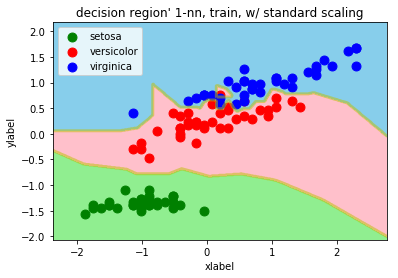

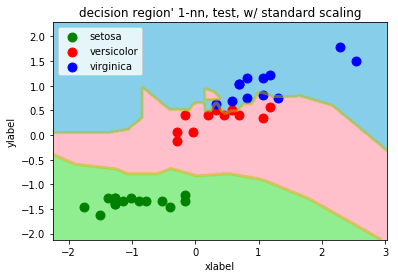

<without standard scaling>
acc : 0.8947368421052632
precision : 0.8897435897435897
recall : 0.8863636363636364
f1 : 0.8838383838383838
confusion matrix 
 [[15  0  0]
 [ 0 10  1]
 [ 0  3  9]]


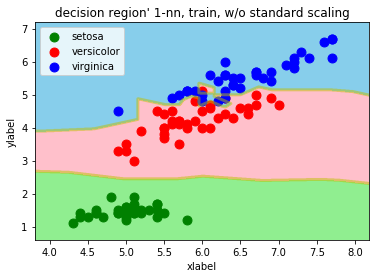

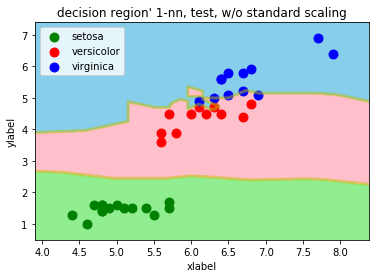

3-nn
<with standard scaling>
acc : 0.9473684210526315
precision : 0.9419191919191919
recall : 0.9419191919191919
f1 : 0.9419191919191919
confusion matrix 
 [[15  0  0]
 [ 0 10  1]
 [ 0  1 11]]


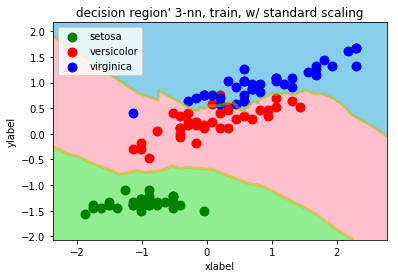

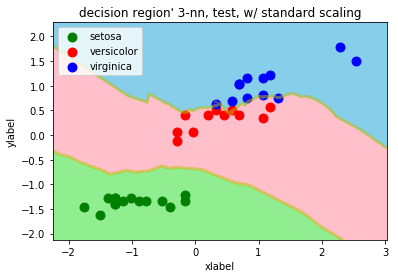

<without standard scaling>
acc : 0.9473684210526315
precision : 0.9419191919191919
recall : 0.9419191919191919
f1 : 0.9419191919191919
confusion matrix 
 [[15  0  0]
 [ 0 10  1]
 [ 0  1 11]]


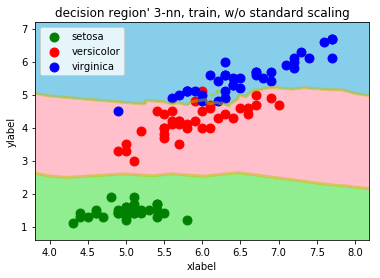

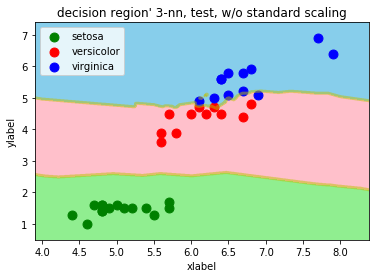

5-nn
<with standard scaling>
acc : 0.9473684210526315
precision : 0.9419191919191919
recall : 0.9419191919191919
f1 : 0.9419191919191919
confusion matrix 
 [[15  0  0]
 [ 0 10  1]
 [ 0  1 11]]


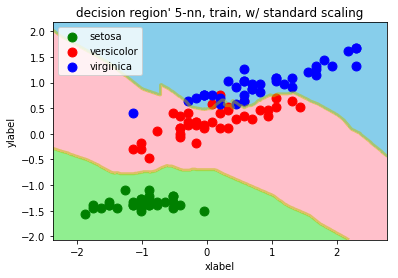

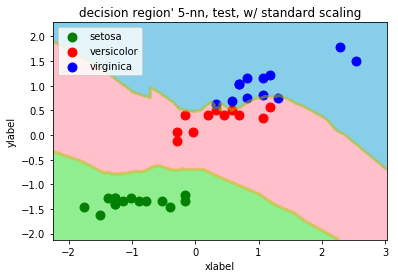

<without standard scaling>
acc : 0.9736842105263158
precision : 0.9722222222222222
recall : 0.9722222222222222
f1 : 0.9710144927536232
confusion matrix 
 [[15  0  0]
 [ 0 11  0]
 [ 0  1 11]]


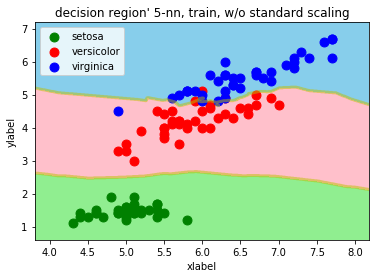

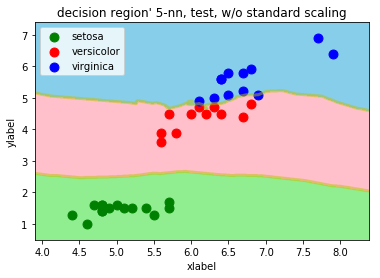

Logistic Regression
<with standard scaling>
acc : 0.868421052631579
precision : 0.9019607843137255
recall : 0.8484848484848485
f1 : 0.8444895199459094
confusion matrix 
 [[15  0  0]
 [ 0  6  5]
 [ 0  0 12]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


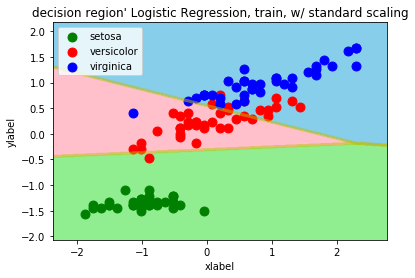

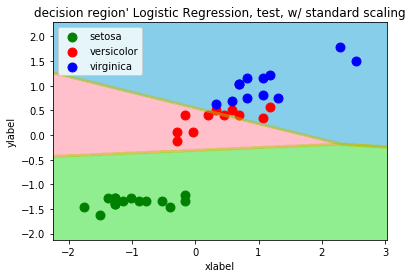

<without standard scaling>
acc : 0.9210526315789473
precision : 0.9153846153846154
recall : 0.9116161616161617
f1 : 0.9123809523809524
confusion matrix 
 [[15  0  0]
 [ 0  9  2]
 [ 0  1 11]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


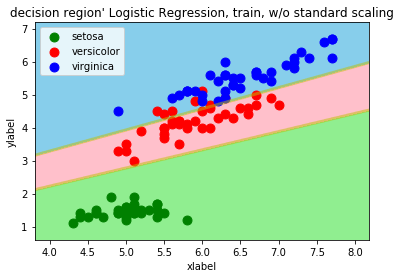

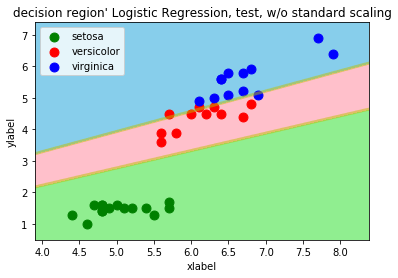

SVM
<with standard scaling>
acc : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0
confusion matrix 
 [[15  0  0]
 [ 0 11  0]
 [ 0  0 12]]


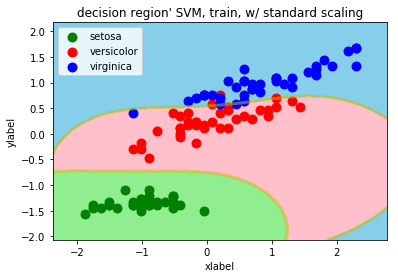

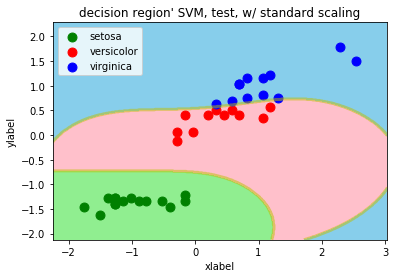

<without standard scaling>
acc : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0
confusion matrix 
 [[15  0  0]
 [ 0 11  0]
 [ 0  0 12]]


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


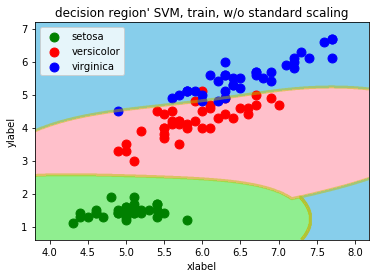

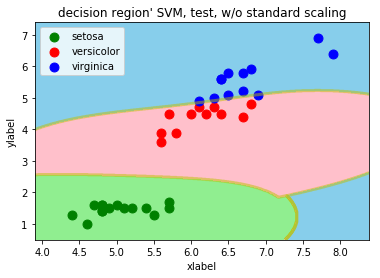

Decision Tree
<with standard scaling>
acc : 0.9736842105263158
precision : 0.9722222222222222
recall : 0.9722222222222222
f1 : 0.9710144927536232
confusion matrix 
 [[15  0  0]
 [ 0 11  0]
 [ 0  1 11]]


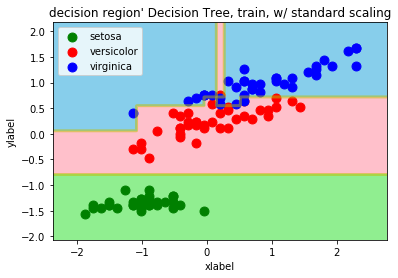

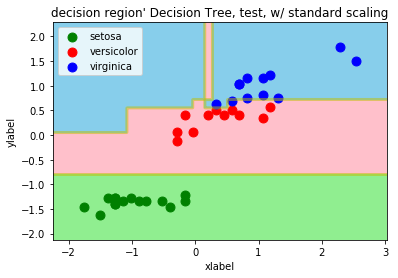

<without standard scaling>
acc : 0.9736842105263158
precision : 0.9722222222222222
recall : 0.9722222222222222
f1 : 0.9710144927536232
confusion matrix 
 [[15  0  0]
 [ 0 11  0]
 [ 0  1 11]]


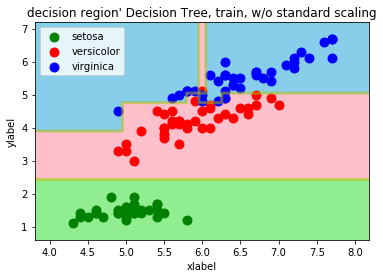

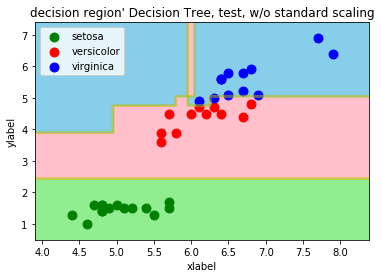

Random Forest
<with standard scaling>
acc : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0
confusion matrix 
 [[15  0  0]
 [ 0 11  0]
 [ 0  0 12]]


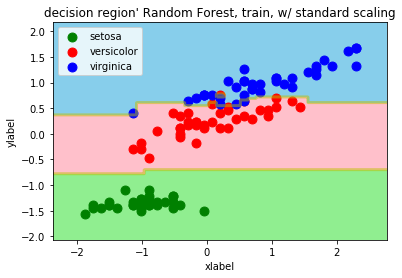

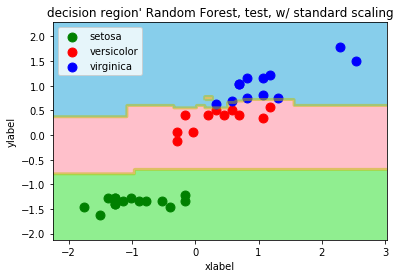

<without standard scaling>
acc : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0
confusion matrix 
 [[15  0  0]
 [ 0 11  0]
 [ 0  0 12]]


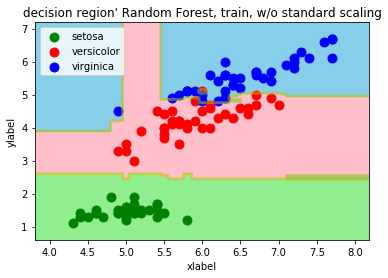

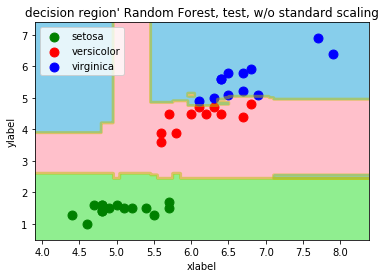

In [22]:
X_train_ndarray = np.array(X_train)
X_test_ndarray = np.array(X_test)

models = [neigh_1, neigh_3, neigh_5, logistic_reg, svc, tree, random_forest]
model_names = ["1-nn", "3-nn", "5-nn", "Logistic Regression", "SVM", "Decision Tree", "Random Forest"]
for model, model_name in zip(models, model_names):
    print(model_name)
    
    print("<with standard scaling>")
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)
    print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(*evaluate_multi(y_test, y_pred)))
    decision_region_3dim(X_train_transformed, y_train, model, title="decision region' {}, {}, w/ standard scaling".format(model_name, "train"))
    decision_region_3dim(X_test_transformed, y_test, model, title="decision region' {}, {}, w/ standard scaling".format(model_name, "test"))
    
    print("<without standard scaling>")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(*evaluate_multi(y_test, y_pred)))
    decision_region_3dim(X_train_ndarray, y_train, model, title="decision region' {}, {}, w/o standard scaling".format(model_name, "train"))
    decision_region_3dim(X_test_ndarray, y_test, model, title="decision region' {}, {}, w/o standard scaling".format(model_name, "test"))

In [23]:
# マイクロ平均も見る。acc, precision, recall, f1が全て同じになる

models = [neigh_1, neigh_3, neigh_5, logistic_reg, svc, tree, random_forest]
model_names = ["1-nn", "3-nn", "5-nn", "Logistic Regression", "SVM", "Decision Tree", "Random Forest"]
for model, model_name in zip(models, model_names):
    print(model_name)
    
    print("<with standard scaling>")
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)
    print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(*evaluate_multi(y_test, y_pred, average='micro')))

    print("<without standard scaling>")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(*evaluate_multi(y_test, y_pred, average='micro')))


1-nn
<with standard scaling>
acc : 0.8947368421052632
precision : 0.8947368421052632
recall : 0.8947368421052632
f1 : 0.8947368421052632
confusion matrix 
 [[15  0  0]
 [ 0 10  1]
 [ 0  3  9]]
<without standard scaling>
acc : 0.8947368421052632
precision : 0.8947368421052632
recall : 0.8947368421052632
f1 : 0.8947368421052632
confusion matrix 
 [[15  0  0]
 [ 0 10  1]
 [ 0  3  9]]
3-nn
<with standard scaling>
acc : 0.9473684210526315
precision : 0.9473684210526315
recall : 0.9473684210526315
f1 : 0.9473684210526315
confusion matrix 
 [[15  0  0]
 [ 0 10  1]
 [ 0  1 11]]
<without standard scaling>
acc : 0.9473684210526315
precision : 0.9473684210526315
recall : 0.9473684210526315
f1 : 0.9473684210526315
confusion matrix 
 [[15  0  0]
 [ 0 10  1]
 [ 0  1 11]]
5-nn
<with standard scaling>
acc : 0.9473684210526315
precision : 0.9473684210526315
recall : 0.9473684210526315
f1 : 0.9473684210526315
confusion matrix 
 [[15  0  0]
 [ 0 10  1]
 [ 0  1 11]]
<without standard scaling>
acc : 0.9736

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from